# Zillow Regression Project
### By Carl Griffin
### June 15, 2021

In [12]:
import numpy as np
import pandas as pd
import math
from acquire import get_zillow_data
from wrangle_zillow import prep_zillow_data, wrangle_zillow, train_validate_test, Min_Max_Scaler, outlier_calculation
from evaluate import baseline_mean_errors, baseline_median_errors, plot_residuals, regression_errors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

## Project Planning
### Initial Questions
- What constitutes a single unit property?
- What features are the best drivers for predicting a single unit property's value?
### Initial Hypotheses

- $H_0$: The features number of bedrooms, number of bathrooms, and square feet offer no predictive value for a single unit property's value.
- $H_a$: These features help predict a single unit property's value.



### Acquire and examine the data

Acquire the data from the zillow database ('Single Family Residential' properties from  May-Aug, 2017)



In [4]:
df = get_zillow_data()

In [5]:
df

,propertylandusetypeid,transactiondate,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,fips
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48,6037.0
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90,6037.0
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69,6037.0
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72,6059.0
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27,6037.0
...,...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68,6059.0
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88,6059.0
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03,6037.0
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66,6037.0


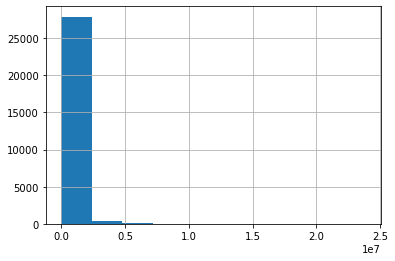

In [8]:
df.taxvaluedollarcnt.hist()
plt.show()

In [9]:
df.isnull().sum()

propertylandusetypeid            0
transactiondate                  0
calculatedfinishedsquarefeet    73
bedroomcnt                       0
bathroomcnt                      0
taxvaluedollarcnt                1
taxamount                        1
fips                             0
county_name                      0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28419 non-null  float64
 1   transactiondate               28419 non-null  object 
 2   calculatedfinishedsquarefeet  28346 non-null  float64
 3   bedroomcnt                    28419 non-null  float64
 4   bathroomcnt                   28419 non-null  float64
 5   taxvaluedollarcnt             28418 non-null  float64
 6   taxamount                     28418 non-null  float64
 7   fips                          28419 non-null  float64
 8   county_name                   28419 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.0+ MB


### Prep the data

In [13]:
df = prep_zillow_data(df)

In [ ]:
# Remove nulls from calculatedsquarefeet
df.loc[df['calculatedfinishedsquarefeet'].isin(['NaN'])].head()
indexsize = df.loc[df['calculatedfinishedsquarefeet'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [ ]:
# Remove nulls from taxvaluedollarcnt
df.loc[df['taxvaluedollarcnt'].isin(['NaN'])].head()
indexsize = df.loc[df['taxvaluedollarcnt'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [ ]:
# Remove nulls from taxamount
df.loc[df['taxamount'].isin(['NaN'])].head()
indexsize = df.loc[df['taxamount'].isin(['NaN'])].index
df.drop(indexsize, inplace=True)

In [ ]:
df.shape

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28344 entries, 0 to 28418
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         28344 non-null  float64
 1   transactiondate               28344 non-null  object 
 2   calculatedfinishedsquarefeet  28344 non-null  float64
 3   bedroomcnt                    28344 non-null  float64
 4   bathroomcnt                   28344 non-null  float64
 5   taxvaluedollarcnt             28344 non-null  float64
 6   taxamount                     28344 non-null  float64
 7   fips                          28344 non-null  float64
 8   county_name                   28344 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.2+ MB


In [ ]:
# Rename the columns into something more readable
df = df.rename(columns={'propertylandusetypeid': 'land_use_typeid', 'bathroomcnt': 'num_bathrooms', 'bedroomcnt': 'num_bedrooms',
                       'calculatedfinishedsquarefeet': 'square_feet', 'taxvaluedollarcnt': 'appraised_value', 'taxamount': 'taxes'})

### Explore the Data

In [ ]:
df.square_feet.describe()

In [ ]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

In [ ]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

In [ ]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [ ]:
df = outlier_calculation(df, 'num_bedrooms')

In [ ]:
sns.boxplot(data=df.num_bedrooms)
plt.title('Distribution of number of bedrooms')
plt.show()

In [ ]:
df = outlier_calculation(df, 'num_bathrooms')

In [ ]:
sns.boxplot(data=df.num_bathrooms)
plt.title('Distribution of number of bathrooms')
plt.show()

In [ ]:
df = outlier_calculation(df, 'square_feet')

In [ ]:
sns.boxplot(data=df.square_feet)
plt.title('Distribution of square_feet')
plt.show()

In [ ]:
df.info()

In [ ]:
# Plot with outliers removed
sns.boxplot(data=df.square_feet)
plt.title('Distribution of sq ft')
plt.show()

In [ ]:
sns.boxplot(data=df.appraised_value)
plt.title('Distribution of appraised value')
plt.show()

In [ ]:
df.appraised_value.hist()
plt.show()

In [ ]:
df.transactiondate.value_counts(dropna=False, ascending=True)

In [ ]:
df.info()

In [ ]:
# Drop the columns not needed for modeling
df1 = df.drop(columns=['transactiondate', 'land_use_typeid', 'taxes', 'fips', 'county_name'])

In [ ]:
df1


#### Split the data

In [ ]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df1, 'appraised_value')

In [ ]:
y_train

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
train.head()

#### Scale the data

In [ ]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [ ]:
X_train_scaled

In [ ]:
# Plot the pairs
sns.pairplot(train, kind = 'reg', corner=True, plot_kws = {'line_kws': {'color': 'blue'}})

In [ ]:
# Create a heatmap to show correlations
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True)

plt.title('Correlation Heatmap of Variables')
plt.show()

#### Takeaways

According to the graphs above, the number of bathrooms are the most closely correlated to the appraised value followed by square feet.

#### Statistical Modeling

Hypothesis (using pearsonr):
    
- $H_O$:  There is no correlation between number of bathrooms and appraised value.

- $H_a$:  There is a correlation between number of bathrooms and appraised value.

In [ ]:
corr, p = stats.pearsonr(train.num_bathrooms, train.appraised_value)
# set alpha
alpha = 0.05
print(corr, p)

if p < alpha:
    print(f'\nWe can reject the null hypothesis.')
else:
    print(f'\nWe fail to reject the null hypothesis.')

Independent T-test:

Hypothesis (using T_test):
    
- $H_O$:  There is no correlation between number of bathrooms and appraised value.

- $H_a$:  There is a correlation between number of bathrooms and appraised value.

In [ ]:
t, p = stats.ttest_ind(train.appraised_value, train.square_feet, equal_var=False)

In [ ]:
t, p

Using the same alpha as before, we can reject the null hypothesis as p < alpha.

### Modeling and Evaluation

Establish a baseline

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict taxvaluedollarcnt_pred_mean
AV_pred_mean = y_train['appraised_value'].mean()
y_train['AV_pred_mean'] = AV_pred_mean
y_validate['AV_pred_mean'] = AV_pred_mean
y_test['AV_pred_mean'] = AV_pred_mean

# 2. compute taxvaluedollarcnt_pred_median
AV_pred_median = y_train['appraised_value'].median()
y_train['AV_pred_median'] = AV_pred_median
y_validate['AV_pred_median'] = AV_pred_median
y_test['AV_pred_median'] = AV_pred_median

In [ ]:
y_train.head()

In [ ]:
#Evaluate the baseline model using the mean
baseline_mean_errors(y_train.appraised_value)

In [ ]:
#Evaluate the baseline model using the median
baseline_median_errors(y_train.appraised_value)

In [ ]:
y_validate.head()

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16, 8))
plt.hist(y_train.appraised_value, color='yellow', alpha=.6, label="Actual Value", log=True)
plt.vlines(y_train.appraised_value.mean(), 0, 10**5, color='red', label="Predicted Prop Value - Mean")
plt.vlines(y_train.appraised_value.median(), 0, 10**5, color='blue', label="Predicted Prop Value - Median")
plt.xlabel("Appraised Property Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

#### Takeaways

- The predicted mean value performed better than the median.

In [ ]:
y_train.head()

In [ ]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'AV_pred_median'}, inplace=True)
y_validate.drop(columns={'AV_pred_median'}, inplace=True)
y_test.drop(columns={'AV_pred_median'}, inplace=True)
y_train.head()

In [ ]:
y_train.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'AV_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

Linear Regression (lm)

In [ ]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled)

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['appraised_value']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['appraised_value']


In [ ]:
y_train.head()

In [ ]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
regression_errors(y_train.appraised_value, y_train.yhat_lm)

LassoLars (lars)

In [ ]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_lars'] = lars.predict(X_train_scaled)


In [ ]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_lars)

#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
regression_errors(y_train.appraised_value, y_train.yhat_lars)

TweedieRegressor (glm)

In [ ]:
# create the model object
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.appraised_value)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled)


In [ ]:
#Use evaluate model to visualize the residuals
plot_residuals(y_train.appraised_value, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
regression_errors(y_train.appraised_value, y_train.yhat_glm)

#### Takeaway

- The best modeling turns out to be the Lasso/Lars model, but they were all close.
- Lasso/Lars had the best r^2.

In [ ]:
# predict validate
y_test['yhat_lars'] = lars.predict(X_test_scaled)

# compute residuals
y_test['residual'] = y_test['yhat_lars'] - y_test['appraised_value']
y_test['baseline_residual'] = y_test['yhat_baseline'] - y_test['appraised_value']

#How does the GLM model perform on out of sample data?
regression_errors(y_test.appraised_value, y_test.yhat_lars)

In [ ]:
y_test.head()

In [ ]:
#Use evaluate model to visualize the residuals
plot_residuals(y_test.appraised_value, y_test.yhat_lars)
a_plot = sns.lmplot(x = 'appraised_value', y = 'yhat_lars', data = y_test, height = 6, aspect = 2, x_bins=50,  fit_reg=True, line_kws={"color":"orange"})
a_plot.set(xlim=(0, 2000000), ylim=(0,1000000))
plt.show()

### Additional required data

- How do tax rate differ between the 3 counties?
- (FIPS: 6037 - Los Angeles County, California
-  6059 - Orange County, California
-  6111 - Ventura County, California)

In [6]:
# Add the county name into the dataframe
df['county_name'] = df['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})


In [7]:
df

,propertylandusetypeid,transactiondate,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,fips,county_name
0,261.0,2017-07-21,1316.0,3.0,2.0,205123.0,2627.48,6037.0,Los Angeles
1,261.0,2017-06-23,1458.0,3.0,2.0,136104.0,2319.90,6037.0,Los Angeles
2,261.0,2017-06-30,1421.0,2.0,1.0,35606.0,543.69,6037.0,Los Angeles
3,261.0,2017-06-01,2541.0,4.0,3.0,880456.0,9819.72,6059.0,Orange
4,261.0,2017-08-23,1491.0,3.0,2.0,107110.0,1399.27,6037.0,Los Angeles
...,...,...,...,...,...,...,...,...,...
28414,261.0,2017-08-31,1187.0,4.0,1.5,465999.0,5552.68,6059.0,Orange
28415,261.0,2017-08-31,3015.0,5.0,3.0,852813.0,11662.88,6059.0,Orange
28416,261.0,2017-08-31,2992.0,5.0,3.0,1120000.0,13663.03,6037.0,Los Angeles
28417,261.0,2017-08-31,1574.0,3.0,3.0,563463.0,6903.66,6037.0,Los Angeles


In [15]:
# show counts by county
df.county_name.value_counts()

Los Angeles    17933
Orange          7743
Ventura         2668
Name: county_name, dtype: int64

In [17]:
df['tax_rate'] = (df['taxes'] / df['appraised_value'])

print(df.groupby('county_name').tax_rate.mean())

KeyError: 'taxes'